<a href="https://colab.research.google.com/github/VinGit-droid/Martingale/blob/main/Martingale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some PIP Installs

In [1]:
pip install alpaca_trade_api

     |████████████████████████████████| 204kB 7.1MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 


In [ ]:
#pip install nest_asyncio

In [ ]:
#pip install backtesting

#*Importing Libraries*

In [2]:
import pandas as pd
#import talib
#import ta
import numpy as np
import matplotlib.pyplot as plt
#from backtesting import Backtest, Strategy

from pylab import rcParams

#from backtesting import Backtest, Strategy
#from backtesting.lib import crossover

import datetime
#import yfinance as yf
import pandas_datareader as pdr
import time
import threading
from IPython.display import clear_output
import sys
#import talib
import alpaca_trade_api as tradeapi
from IPython.display import clear_output


## *Initializing the API*

In [3]:
api = tradeapi.REST('PKLSSJRW3WR0GB5W5BPR', 'i3RmA1i9BnS5DsgZ6RT1W67BMz6L2I9UINHBYq5n', base_url='https://paper-api.alpaca.markets') # or use ENV Vars shown below
account = api.get_account()
api.list_positions()

[Position({   'asset_class': 'us_equity',
     'asset_id': '80e04a93-e1a8-4503-ab61-2ef1992650b4',
     'avg_entry_price': '27.4762025316455696',
     'change_today': '0.0171388597411682',
     'cost_basis': '4341.24',
     'current_price': '29.08',
     'exchange': 'NYSE',
     'lastday_price': '28.59',
     'market_value': '4594.64',
     'qty': '158',
     'side': 'long',
     'symbol': 'PLTR',
     'unrealized_intraday_pl': '77.42',
     'unrealized_intraday_plpc': '0.0171388597411682',
     'unrealized_pl': '253.4',
     'unrealized_plpc': '0.058370419511476'}),
 Position({   'asset_class': 'us_equity',
     'asset_id': '9e4ef521-d808-4471-b5a5-b3abd456a1f2',
     'avg_entry_price': '21.35',
     'change_today': '-0.0004653327128897',
     'cost_basis': '20709.5',
     'current_price': '21.48',
     'exchange': 'NYSE',
     'lastday_price': '21.49',
     'market_value': '20835.6',
     'qty': '970',
     'side': 'long',
     'symbol': 'GPS',
     'unrealized_intraday_pl': '-9.7',


## *Functions for the Martingale Trading*

In [4]:
def buy_sell(test):

  # Create column for previous price
  test['prev_close'] = test['close'].shift(1)
  # Generate buy and sell signal for price increase and decrease respectively. And create consolidated 'signal' column by addition of both buy and sell signals
  test['long_signal'] = np.where(test['close'] < test['prev_close'], 1, 0)

  test.reset_index(inplace=True)
  for i in range(test.shape[0]):
    if i > 0:
      h = i-1
      if ( (test.loc[i, 'long_signal'] == 0) & (test.loc[h, 'long_signal'] == 0) ):

        test.loc[i,'short_signal'] = -1

      else:

        test.loc[i,'short_signal'] = 0

  test['signal'] = test['short_signal'] + test['long_signal']

  for i in range(test.shape[0]):
    if i > 0:
      h = i-1
      if ( (test.loc[i, 'short_signal'] == -1) & (test.loc[h, 'short_signal'] == -1) ):

        test.loc[i,'new_signal'] = 0

      else:

        test.loc[i,'new_signal'] = test.loc[i,'signal'] 

  test['BUY_SELL'] = np.where(test['new_signal'] == 1, 'Buy', test['new_signal'] )
  test['BUY_SELL'] = np.where(test['new_signal'] == -1, 'Sell', test['BUY_SELL'] )
  test = test[['time','symbol','close','prev_close','BUY_SELL']]
  return test

In [5]:
def phase_1(test):
  test = buy_sell(test)
  test['Buy_Qty'] = 0
  n = 1
  t = 0
  for i,row in test.iterrows():
    print(n)
    clear_output(wait=True)
    if test.loc[i,'BUY_SELL'] == 'Buy':

      n *= 5
      test.loc[i,'Buy_Qty'] = n/5
      test.loc[i,'Trade_No'] = t

    elif test.loc[i,'BUY_SELL'] == 'Sell':

      test.loc[i,'Trade_No'] = t
      n = 1
      t += 1
      continue

    #test['Sell_Qty'] = test.groupby(['Trade_No'])['Buy_Qty'].transform('sum')
    #test['Trade_No'] = test['Trade_No'].fillna(0)
    #test["Trade_No"] = test["Trade_No"].astype(int)

  return test

In [7]:
def phase_2(test):

  test = phase_1(test)
  test['Trade_No'] = test['Trade_No'].fillna(0)
  test["Trade_No"] = test["Trade_No"].astype(int)
  test['Sell_Qty'] = test.groupby(['Trade_No'])['Buy_Qty'].transform('sum')

  

  for i,row in test.iterrows():
      print(i)
      clear_output(wait=True)
      if test.loc[i,'BUY_SELL'] == 'Buy':
        test.loc[i,'Quantity'] = test.loc[i,'Buy_Qty']
      elif test.loc[i,'BUY_SELL'] == 'Sell':
        test.loc[i,'Quantity'] = test.loc[i,'Sell_Qty']
      else:
        test.loc[i,'Quantity'] = 0

  test = test[['time','symbol','close','prev_close','Trade_No','BUY_SELL','Quantity']]
  test['Price'] = test['Quantity'] * test['close']
  test["Quantity"] = test["Quantity"].astype(int)
  test['Total_Price'] = test.groupby(['Trade_No','BUY_SELL'])['Price'].transform('sum')

  return test

## *Fetching Raw Data*

In [47]:
#'NIO','GPS','UPRO'
from datetime import timedelta
#df['enddate'] = pd.to_datetime(df['enddate']) - timedelta(hours=3)
NY = 'America/Chicago'

start = pd.Timestamp.now(tz=NY).isoformat()
start = pd.Timestamp('2020-12-7 08:30', tz='America/Denver')

#start = pd.to_datetime(start) - timedelta(minutes=15)
#start = start.isoformat()
start

Timestamp('2020-12-07 08:30:00-0700', tz='America/Denver')

In [48]:
#@title Default title text
NY = 'America/Chicago'
#start=pd.Timestamp('2020-12-02', tz=NY).isoformat()
#start=pd.Timestamp.now(tz=NY).isoformat()

end=pd.Timestamp('2020-12-30', tz=NY).isoformat()
barset = api.get_barset('PLTR', '5Min',start=start, end=end).df
#barset = api.get_barset('GPS', '5Min', limit=3).df

test = barset['PLTR']
test['symbol'] = 'PLTR'
test = test[['symbol','close']]
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,symbol,close
time,,
2020-12-04 11:05:00-05:00,PLTR,23.960
2020-12-04 11:10:00-05:00,PLTR,23.830
2020-12-04 11:15:00-05:00,PLTR,23.670
2020-12-04 11:20:00-05:00,PLTR,23.650
2020-12-04 11:25:00-05:00,PLTR,23.800
...,...,...
2020-12-07 11:35:00-05:00,PLTR,27.330
2020-12-07 11:40:00-05:00,PLTR,27.070
2020-12-07 11:45:00-05:00,PLTR,27.360


In [52]:
test = phase_2(test)
test

,time,symbol,close,prev_close,Trade_No,BUY_SELL,Quantity,Price,Total_Price
0,2020-12-04 11:05:00-05:00,PLTR,23.960,NaN,0,nan,0,0.000,0.000
1,2020-12-04 11:10:00-05:00,PLTR,23.830,23.960,0,Buy,1,23.830,3702.180
2,2020-12-04 11:15:00-05:00,PLTR,23.670,23.830,0,Buy,5,118.350,3702.180
3,2020-12-04 11:20:00-05:00,PLTR,23.650,23.670,0,Buy,25,591.250,3702.180
4,2020-12-04 11:25:00-05:00,PLTR,23.800,23.650,0,0.0,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...
95,2020-12-07 11:35:00-05:00,PLTR,27.330,27.630,13,Buy,5,136.650,20986.655
96,2020-12-07 11:40:00-05:00,PLTR,27.070,27.330,13,Buy,25,676.750,20986.655
97,2020-12-07 11:45:00-05:00,PLTR,27.360,27.070,0,0.0,0,0.000,0.000
98,2020-12-07 11:50:00-05:00,PLTR,27.015,27.360,13,Buy,125,3376.875,20986.655


In [50]:
test.to_csv('mart_all.csv')
test["symbol"] = test["symbol"].apply(lambda x: str(x))
test["BUY_SELL"] = test["BUY_SELL"].apply(lambda x: str(x))
#df.particulars = df.particulars.apply(lambda x: str(x))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype                           
---  ------       --------------  -----                           
 0   time         100 non-null    datetime64[ns, America/New_York]
 1   symbol       100 non-null    object                          
 2   close        100 non-null    float64                         
 3   prev_close   99 non-null     float64                         
 4   Trade_No     100 non-null    int64                           
 5   BUY_SELL     100 non-null    object                          
 6   Quantity     100 non-null    int64                           
 7   Price        100 non-null    float64                         
 8   Total_Price  100 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(2)
memory usage: 7.2+ KB


In [54]:
api.submit_order(symbol='PLTR', qty=2, side='buy', type='market', time_in_force='gtc')

Order({   'asset_class': 'us_equity',
    'asset_id': '80e04a93-e1a8-4503-ab61-2ef1992650b4',
    'canceled_at': None,
    'client_order_id': 'cc5a7eca-67fe-4123-9034-be4c1b8e9173',
    'created_at': '2020-12-07T17:37:24.603287Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'filled_qty': '0',
    'hwm': None,
    'id': '19f52bcc-035d-4ab9-a8eb-c2750494c22a',
    'legs': None,
    'limit_price': None,
    'order_class': '',
    'order_type': 'market',
    'qty': '2',
    'replaced_at': None,
    'replaced_by': None,
    'replaces': None,
    'side': 'buy',
    'status': 'accepted',
    'stop_price': None,
    'submitted_at': '2020-12-07T17:37:24.594703Z',
    'symbol': 'PLTR',
    'time_in_force': 'gtc',
    'trail_percent': None,
    'trail_price': None,
    'type': 'market',
    'updated_at': '2020-12-07T17:37:24.603287Z'})

## *Buy* and *Sell* Yet to be Done

In [60]:
#test = test.tail(1)
for i, row in test.iterrows():
  print(i)
  global n
  if test.loc[i,'BUY_SELL'] == 'Buy':
    n = test.loc[i,'Quantity']
    print(n)
    Trade_No = test.loc[i,'Trade_No']
    Current_Price = test.loc[i,'Price']
    Total_Price = test.loc[i,'Total_Price']

    print('********************************************')
    print('Buy for Trade Number',Trade_No)
    print('Buy Quantity',n)
    print('Current Price is',Current_Price)
    print('Total_Price for this trade is ',Total_Price)

    close = test.loc[i,'close']
    sym = str(test.loc[i,'symbol'])
    n = int(n)

    #print(type(sym),type(n))

    api.submit_order(symbol=sym, qty=n, side='buy', type='market', time_in_force='gtc')

  elif test.loc[i,'BUY_SELL'] == 'Sell':
    n = test.loc[i,'Quantity']
    Trade_No = test.loc[i,'Trade_No']
    Current_Price = test.loc[i,'Price']
    Total_Price = test.loc[i,'Total_Price']


    print('********************************************')
    print('Sell for Trade Number',Trade_No)
    print('Sell Quantity',Trade_No)
    print('Current Price is',Current_Price)
    print('Total_Price for this trade is ',Total_Price)

    close = test.loc[i,'close']
    sym = str(test.loc[i,'symbol'])
    n = int(n)
    
    api.submit_order(symbol=sym,qty=n, side='sell', type='market', time_in_force='gtc')
    #break

0
1
1
********************************************
Buy for Trade Number 0
Buy Quantity 1
Current Price is 23.83
Total_Price for this trade is  3702.1800000000003
<class 'str'> <class 'int'>
2
5
********************************************
Buy for Trade Number 0
Buy Quantity 5
Current Price is 118.35000000000001
Total_Price for this trade is  3702.1800000000003
<class 'str'> <class 'int'>
3
25
********************************************
Buy for Trade Number 0
Buy Quantity 25
Current Price is 591.25
Total_Price for this trade is  3702.1800000000003
<class 'str'> <class 'int'>
4
5
125
********************************************
Buy for Trade Number 0
Buy Quantity 125
Current Price is 2968.75
Total_Price for this trade is  3702.1800000000003
<class 'str'> <class 'int'>
6
7
********************************************
Sell for Trade Number 0
Sell Quantity 0
Current Price is 3732.3
Total_Price for this trade is  3732.3


APIError: ignored

In [ ]:
test = test.tail(1)
for i, row in test.iterrows():
  print(i)
  global n
  #n *= 5
  if test.loc[i,'BUY_SELL'] == 'Buy':
    n=1

    test.loc[i,'Quantity'] = 1
    test.loc[i,'Trade_No'] = i
    print('Buy signal @row',i)

    close = test.loc[i,'close']
    sym = test.loc[i,'symbol']

    df = pd.DataFrame()
    k = i+1
    df = test[k:]

    for j, row in df.iterrows():
      
      if df.loc[j,'BUY_SELL'] == 'Buy':
        n = int(n* 5)
        print(n)
        test.loc[j,'Quantity'] = n
        test.loc[j,'Trade_No'] = i

        api.submit_order(symbol=sym, qty=n, side='buy', type='market', time_in_force='gtc')

      else:
        #test.loc[j,'Quantity'] = n
        test.loc[j,'Trade_No'] = i


      if df.loc[j,'BUY_SELL'] == 'Sell':
        Total = test['Quantity'].sum(skipna=True)
        #Total = sum(test.Quantity)
        #Total = test.Quantity.sum(numeric_only=True)

        
        test.loc[j,'Quantity'] = Total
        test.loc[j,'Trade_No'] = i
        print(test)
        print(Total)
        api.submit_order(symbol=sym,qty=Total, side='sell', type='market', time_in_force='gtc')
        break
  

0
1
Buy signal @row 1
5
25
125
625
2
3
Buy signal @row 3
5


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


25
125
4
Buy signal @row 4
5
25
5
Buy signal @row 5
5
6
Buy signal @row 6


In [ ]:
import alpaca_trade_api as tradeapi

api = tradeapi.REST()

# Submit a market order and assign it a Client Order ID.
api.submit_order(
    symbol='AAPL',
    qty=1,
    side='buy',
    type='market',
    time_in_force='gtc',
    client_order_id='my_first_order'
)

# Get our order using its Client Order ID.
my_order = api.get_order_by_client_order_id('my_first_order')
print('Got order #{}'.format(my_order.id))



In [ ]:
test = df
class CHAIKIN(Strategy):
    
    def init(self):
        
        Close = self.data.close
        BUY_SELL = self.data.BUY_SELL
        
        
    def next(self):
        
        if self.data.BUY_SELL == 1:
            self.buy()
            
        elif self.data.BUY_SELL == -1:
            self.sell()
        
        

bt = Backtest(test, CHAIKIN, cash=10000, commission=.002)
bt.run()
#bt.plot()

In [ ]:
test2.to_csv('testing.csv')

In [ ]:
# Initialise 'quantity' column 
test2['quantity'] = 0

# Start with 1 stock, long position
test2['BUY_SELL'].iloc[0] = 'Buy'

# Strategy to double the trade volume or quantity on losing trades
for i in range(test2.shape[0]):
  if i == 0:
    test2['quantity'].iloc[0] = 1
  else:
    if test2['BUY_SELL'].iloc[i] == 'Buy':
      test2['quantity'].iloc[i] = test2['quantity'].iloc[i-1]
    if test2['BUY_SELL'].iloc[i] == 'Sell':
      test2['quantity'].iloc[i] = test2['quantity'].iloc[i-1]*5
    if test2['BUY_SELL'].iloc[i] == 0:
      test2['quantity'].iloc[i] = test2['quantity'].iloc[i-1]
      
test2.head() 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,time,close,prev_price,long_signal,short_signal,signal,new_signal,BUY_SELL,quantity
0,2020-08-03 07:10:00-04:00,52.88,NaN,0,NaN,NaN,NaN,Buy,1
1,2020-08-03 09:25:00-04:00,53.06,52.88,0,-1.0,-1.0,-1.0,Sell,5
2,2020-08-03 09:30:00-04:00,52.98,53.06,1,0.0,1.0,1.0,Buy,5
3,2020-08-03 09:35:00-04:00,52.81,52.98,1,0.0,1.0,1.0,Buy,5
4,2020-08-03 09:40:00-04:00,52.91,52.81,0,0.0,0.0,0.0,0.0,0


In [ ]:
# Initialise 'quantity' column 
df_mg['quantity'] = 0

# Start with 1 stock, long position
df_mg['signal'].iloc[0] = 1

# Strategy to double the trade volume or quantity on losing trades
for i in range(df_mg.shape[0]):
  if i == 0:
    df_mg['quantity'].iloc[0] = 1
  else:
    if df_mg['signal'].iloc[i] == 1:
      df_mg['quantity'].iloc[i] = df_mg['quantity'].iloc[i-1]
    if df_mg['signal'].iloc[i] == -1:
      df_mg['quantity'].iloc[i] = df_mg['quantity'].iloc[i-1]*5
    if df_mg['signal'].iloc[i] == 0:
      df_mg['quantity'].iloc[i] = df_mg['quantity'].iloc[i-1]
      
df_mg.head() 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app


,close,prev_price,prev2_price,long_signal,short_signal,signal,quantity
time,,,,,,,
2020-08-03 07:00:00-04:00,431.270,NaN,NaN,0,0,1,1
2020-08-03 07:05:00-04:00,431.600,431.27,NaN,0,0,0,1
2020-08-03 07:10:00-04:00,431.700,431.60,431.27,0,-1,-1,5
2020-08-03 07:15:00-04:00,431.420,431.70,431.60,1,0,1,5
2020-08-03 07:20:00-04:00,432.099,431.42,431.70,0,-1,-1,25


In [ ]:
df_mg.to_csv('trying.csv')

In [ ]:
# Calculate returns
df_mg['returns'] = ((df_mg['close'] - df_mg['prev_price'])/ df_mg['close'])*df_mg['quantity']
df_mg

,open,high,low,close,volume,prev_price,prev2_price,long_signal,short_signal,signal,quantity,returns
time,,,,,,,,,,,,
2020-08-03 07:00:00-04:00,429.520,431.270,429.520,431.270,370,NaN,NaN,0,0,1,1,NaN
2020-08-03 07:05:00-04:00,431.600,431.600,431.600,431.600,150,431.270,NaN,0,0,0,1,7.645968e-04
2020-08-03 07:10:00-04:00,431.280,431.700,431.280,431.700,400,431.600,431.27,0,-1,-1,5,1.158212e-03
2020-08-03 07:15:00-04:00,431.390,431.420,431.390,431.420,200,431.700,431.60,1,0,1,5,-3.245098e-03
2020-08-03 07:20:00-04:00,432.099,432.099,432.099,432.099,100,431.420,431.70,0,-1,-1,25,3.928498e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-27 12:35:00-05:00,116.470,116.520,116.360,116.470,47450,116.470,116.53,0,0,0,-129830212415654715,-0.000000e+00
2020-11-27 12:40:00-05:00,116.460,116.500,116.350,116.420,52973,116.470,116.47,1,0,1,-129830212415654715,5.575941e+13
2020-11-27 12:45:00-05:00,116.430,116.460,116.325,116.340,28145,116.420,116.47,1,0,1,-129830212415654715,8.927641e+13


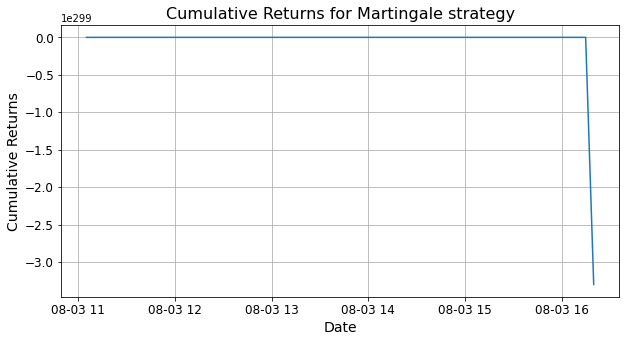

In [ ]:
# Cumulative strategy returns
df_mg['cumulative_returns'] = (df_mg.returns+1).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10,5))
plt.plot(df_mg.cumulative_returns)
plt.grid()

# Define the label for the title of the figure
plt.title('Cumulative Returns for Martingale strategy', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

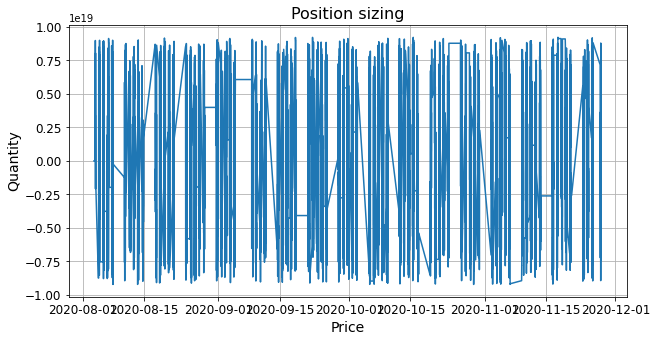

In [ ]:
# Plot position
plt.figure(figsize=(10,5))
plt.plot(df_mg.quantity)
plt.grid()

# Define the label for the title of the figure
plt.title('Position sizing', fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel('Price', fontsize=14)
plt.ylabel('Quantity', fontsize=14)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
for i, row in test.iterrows():
  print(i)
  if test.loc[i,'Buy'] == 1:
    test.loc[i,'CP'] = test.loc[i,'Buy']* test.loc[i,'close']





2020-08-03 07:00:00-04:00
2020-08-03 07:05:00-04:00
2020-08-03 07:10:00-04:00
2020-08-03 07:15:00-04:00
2020-08-03 07:25:00-04:00
2020-08-03 08:05:00-04:00
2020-08-03 08:35:00-04:00
2020-08-03 08:40:00-04:00
2020-08-03 08:45:00-04:00
2020-08-03 08:55:00-04:00
2020-08-03 09:00:00-04:00
2020-08-03 09:10:00-04:00
2020-08-03 09:15:00-04:00
2020-08-03 09:25:00-04:00
2020-08-03 09:30:00-04:00
2020-08-03 09:35:00-04:00
2020-08-03 09:40:00-04:00
2020-08-03 09:45:00-04:00
2020-08-03 09:50:00-04:00
2020-08-03 09:55:00-04:00
2020-08-03 10:00:00-04:00
2020-08-03 10:05:00-04:00
2020-08-03 10:10:00-04:00
2020-08-03 10:15:00-04:00
2020-08-03 10:20:00-04:00
2020-08-03 10:25:00-04:00
2020-08-03 10:30:00-04:00
2020-08-03 10:35:00-04:00
2020-08-03 10:40:00-04:00
2020-08-03 10:45:00-04:00
2020-08-03 10:50:00-04:00
2020-08-03 10:55:00-04:00
2020-08-03 11:00:00-04:00
2020-08-03 11:05:00-04:00
2020-08-03 11:10:00-04:00
2020-08-03 11:15:00-04:00
2020-08-03 11:20:00-04:00
2020-08-03 11:25:00-04:00
2020-08-03 1

In [ ]:
import alpaca_trade_api as tradeapi
import datetime
import nest_asyncio
nest_asyncio.apply()
ALPACA_API_KEY = "PK51BQ2E646WF2DO1LQS"
ALPACA_SECRET_KEY = "o4jXNB5bdc0r3ovFtesT4Qt5ecQxGICXgXk5V2Sd"
USE_POLYGON = False


# Utility to truncate a float value to a certain number of decimal places.
# We'll use this to see if a "penny level" was crossed when we compare prices.
# This is necessary because a price can change by 1/100th of a penny, but we
# can only trade at full-penny increments.
def truncate(val, decimal_places):
    return int(val * 10**decimal_places) / 10**decimal_places


# The MartingaleTrader bets that streaks of increases or decreases in a stock's
# price are likely to break, and increases its bet each time it is wrong.
class MartingaleTrader(object):
    def __init__(self):
        # API authentication keys can be taken from the Alpaca dashboard.
        # https://app.alpaca.markets/paper/dashboard/overview
        self.key_id = ALPACA_API_KEY
        self.secret_key = ALPACA_SECRET_KEY
        self.base_url = 'https://paper-api.alpaca.markets'
        self.data_url = 'https://data.alpaca.markets'

        # The symbol we will be trading
        self.symbol = 'SPY'

        # How many seconds we will wait in between updating the streak values
        self.tick_size = 5
        self.tick_index = 0

        # The percentage of our buying power that we will allocate to a new
        # position after a streak reset
        self.base_bet = 10

        # These variables track the information about the current streak
        self.streak_count = 0
        self.streak_start = 0
        self.streak_increasing = True

        # When this variable is not None, we have an order open
        self.current_order = None

        # The closing price of the last aggregate we saw
        self.last_price = 0

        # used to use tick data as second aggs data (mot every tick, but sec)
        self.last_trade_time = datetime.datetime.utcnow()

        # The connection to the Alpaca API
        self.api = tradeapi.REST(
            self.key_id,
            self.secret_key,
            self.base_url
        )

        # Cancel any open orders so they don't interfere with this script
        self.api.cancel_all_orders()

        try:
            self.position = int(self.api.get_position(self.symbol).qty)
        except:
            # No position exists
            self.position = 0

        # Figure out how much money we have to work with, accounting for margin
        account_info = self.api.get_account()
        self.equity = float(account_info.equity)
        self.margin_multiplier = float(account_info.multiplier)
        total_buying_power = self.margin_multiplier * self.equity
        print(f'Initial total buying power = {total_buying_power}')


    def start_trading(self):
        conn = tradeapi.StreamConn(
            self.key_id,
            self.secret_key,
            base_url=self.base_url,
            data_url=self.data_url,
            data_stream='polygon' if USE_POLYGON else 'alpacadatav1'
        )

        # Listen for second aggregates and perform trading logic
        @conn.on(r'A$', [self.symbol])
        async def handle_agg(conn, channel, data):
            self.tick_index = (self.tick_index + 1) % self.tick_size
            if self.tick_index == 0:
                # It's time to update

                # Update price info
                tick_open = self.last_price
                tick_close = data.close
                self.last_price = tick_close

                self.process_current_tick(tick_open, tick_close)

        # Listen for quote data and perform trading logic
        @conn.on(r'T\..+', [self.symbol])
        async def handle_alpaca_aggs(conn, channel, data):
            now = datetime.datetime.utcnow()
            if now - self.last_trade_time < datetime.timedelta(seconds=1):
                # don't react every tick unless at least 1 second past
                return
            self.last_trade_time = now
            self.tick_index = (self.tick_index + 1) % self.tick_size
            if self.tick_index == 0:
                # It's time to update

                # Update price info
                tick_open = self.last_price
                tick_close = data.price
                self.last_price = tick_close

                self.process_current_tick(tick_open, tick_close)

        # Listen for updates to our orders
        @conn.on(r'trade_updates')
        async def handle_trade(conn, channel, data):
            symbol = data.order['symbol']
            if symbol != self.symbol:
                # The order was for a position unrelated to this script
                return

            event_type = data.event
            qty = int(data.order['filled_qty'])
            side = data.order['side']
            oid = data.order['id']

            if event_type == 'fill' or event_type == 'partial_fill':
                # Our position size has changed
                self.position = int(data.position_qty)
                print(f'New position size due to order fill: {self.position}')
                if (event_type == 'fill' and self.current_order
                    and self.current_order.id == oid):
                    self.current_order = None
            elif event_type == 'rejected' or event_type == 'canceled':
                if self.current_order and self.current_order.id == oid:
                    # Our last order should be removed
                    self.current_order = None
            elif event_type != 'new':
                print(f'Unexpected order event type {event_type} received')

        if USE_POLYGON:
            conn.run([f'A.{self.symbol}', 'trade_updates'])
        else:
            conn.run([f'alpacadatav1/T.{self.symbol}', 'trade_updates'])

    def process_current_tick(self, tick_open, tick_close):
        # Update streak info
        diff = truncate(tick_close, 2) - truncate(tick_open, 2)
        if diff != 0:
            # There was a meaningful change in the price
            self.streak_count += 1
            increasing = tick_open > tick_close
            if self.streak_increasing != increasing:
                # It moved in the opposite direction of the streak.
                # Therefore, the streak is over, and we should reset.

                # Empty out the position
                self.send_order(0)

                # Reset variables
                self.streak_increasing = increasing
                self.streak_start = tick_open
                self.streak_count = 0
            else:
                # Calculate the number of shares we want to be holding
                total_buying_power = self.equity * \
                                     self.margin_multiplier
                target_value = (2 ** self.streak_count) * \
                               (self.base_bet / 100) * total_buying_power
                if target_value > total_buying_power:
                    # Limit the amount we can buy to a bit (1 share)
                    # less than our total buying power
                    target_value = total_buying_power - self.last_price
                target_qty = int(target_value / self.last_price)
                if self.streak_increasing:
                    target_qty = target_qty * -1
                self.send_order(target_qty)
        # Update our account balance
        self.equity = float(self.api.get_account().equity)

    def send_order(self, target_qty):
        # We don't want to have two orders open at once
        if self.current_order is not None:
            self.api.cancel_order(self.current_order.id)

        delta = target_qty - self.position
        if delta == 0:
            return
        print(f'Ordering towards {target_qty}...')
        try:
            if delta > 0:
                buy_qty = delta
                if self.position < 0:
                    buy_qty = min(abs(self.position), buy_qty)
                print(f'Buying {buy_qty} shares.')
                self.current_order = self.api.submit_order(
                    self.symbol, buy_qty, 'buy',
                    'limit', 'day', self.last_price
                )
            elif delta < 0:
                sell_qty = abs(delta)
                if self.position > 0:
                    sell_qty = min(abs(self.position), sell_qty)
                print(f'Selling {sell_qty} shares.')
                self.current_order = self.api.submit_order(
                    self.symbol, sell_qty, 'sell',
                    'limit', 'minute', self.last_price
                )
        except Exception as e:
            print(e)


if __name__ == '__main__':
    trader = MartingaleTrader()
    trader.start_trading()

In [ ]:
for i, row in test2.iterrows():
  if test2.loc[i,'BUY_SELL'] == 'Buy':
    print(i,test2.loc[i,'BUY_SELL'])
    test2.loc[i,'Quantity'] = 1
    test2.loc[i,'Trade_No'] = i
    global q
    q = 1
    df = pd.DataFrame()
    df = test2[i:]

    for j, row in df.iterrows():
      if df.loc[j,'BUY_SELL'] == 'Buy':
        #q = q * 5
        test2.loc[j,'Quantity'] = q*5

      elif df.loc[j,'BUY_SELL'] == 'Sell':
        test2.loc[j,'Quantity'] = q
        test2.loc[j,'Trade_No'] = i

      else:
        test2.loc[j,'Quantity'] = q

